<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/Stitching/Stitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

특징점 추출 + 파노라마 생성까지 목표로!!


참조 1  
https://bkshin.tistory.com/entry/OpenCV-29-%EC%98%AC%EB%B0%94%EB%A5%B8-%EB%A7%A4%EC%B9%AD%EC%A0%90-%EC%B0%BE%EA%B8%B0?category=1148027

이 분이 정리해둔 걸 그저 Colab으로 가져왔다. 감사합니다.

참조 2  
와핑 및 이미지 합치는 부분 참조  
https://stackoverflow.com/questions/64659657/fast-and-robust-image-stitching-algorithm-for-many-images-in-python

참조 3  
와핑 및 이미지 합치는 부분 참조  
https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/?_ga=2.216681310.998951928.1644328070-1208812574.1644328070

참조 4

https://stackoverflow.com/questions/68543804/image-stitching-problem-using-python-and-opencv  
짧고 필요한건 다 있음.  
답변중에 외곡에 대한 보정 부분

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [7]:
from IPython.display import Image, display


Displaying image: earring_1.jpg


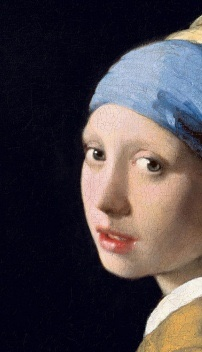


Displaying image: earring_2.jpg


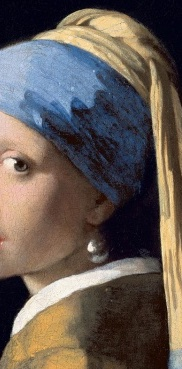


Displaying image: earring_3.jpg


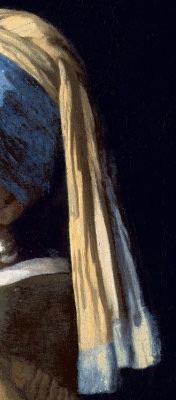

In [8]:
# Some example images
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"{image_file}"))

Colab에서 cv2.imshow는 사용할 수 없단다.  
대신   
from google.colab.patches import cv2_imshow.   
cv2_imshow(<image>)  
를 사용한다.

In [35]:
import cv2, numpy as np
#
from google.colab.patches import cv2_imshow

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])
#gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


In [ ]:

detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)
# 최소 거리 값과 최대 거리 값 확보 ---④
min_dist, max_dist = matches[0].distance, matches[-1].distance
# 최소 거리의 15% 지점을 임계점으로 설정 ---⑤
ratio = 0.2
good_thresh = (max_dist - min_dist) * ratio + min_dist
# 임계점 보다 작은 매칭점만 좋은 매칭점으로 분류 ---⑥
good_matches = [m for m in matches if m.distance < good_thresh]
print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' \
        %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))
# 좋은 매칭점만 그리기 ---⑦
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
#cv2.imshow('Good Match', res)
cv2_imshow(res)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [ ]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = matcher.knnMatch(desc1, desc2, 2)

# 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---⑤
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭만 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력                    
cv2_imshow(res)

In [ ]:
# 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
print(img1.shape)
print(np.int32(dst))

# 좋은 매칭 그려서 출력 ---⑨
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
#cv2_imshow(img2)
cv2_imshow(res)

In [110]:
# find the ROI of a transformation result
def warpRect(rect, H):
    x, y, w, h = rect
    #[0,0] [0,h] [w,0] [w,h]
    corners = np.float32([ [[x, y], [x, y + h - 1], [x + w - 1, y], [x + w - 1, y + h - 1]] ])

    extremum = cv2.transform(corners, H)
    minx, miny = np.min(extremum[:,0]), np.min(extremum[:,1])
    maxx, maxy = np.max(extremum[:,0]), np.max(extremum[:,1])
    xo = int(np.floor(minx))
    yo = int(np.floor(miny))
    wo = int(np.ceil(maxx - minx))
    ho = int(np.ceil(maxy - miny))
    outrect = (xo, yo, wo, ho)
    print(outrect)
    return outrect

In [111]:
# homography matrix is translated to fit in the screen
def coverH(rect, H):
    # obtain bounding box of the result
    x, y, _, _ = warpRect(rect, H)
    # shift amount to the first quadrant
    xpos = int(-x if x < 0 else 0)
    ypos = int(-y if y < 0 else 0)
    # correct the homography matrix so that no point is thrown out
    T = np.array([[1, 0, xpos], [0, 1, ypos], [0, 0, 1]])
    H_corr = T.dot(H)
    return (H_corr, (xpos, ypos))

In [112]:
def size2rect(size):
    return (0, 0, size[1], size[0])

In [ ]:
#T = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
#H_corr = mtrx.dot(T)
# tweak the homography matrix to move the result to the first quadrant
#H_cover, pos = coverH(size2rect(img1.shape), mtrx)
# find the bounding box of the output
#x, y, w, h = warpRect(size2rect(img1.shape), H_cover)
#width, height = x + w, y + h
#print(img1.shape)
warped = cv2.warpPerspective(img2, mtrx, (img2.shape[1], img2.shape[0]))
cv2_imshow(warped)

In [80]:
print(img1.shape)
print(img2.shape)

(3024, 2955, 3)
(3024, 2059, 3)


In [42]:
def warpPano(img1, img2):
    detector = cv2.ORB_create()
    #detector = cv2.xfeatures2d.SIFT_create(400)
    # find the keypoints and descriptors with SIFT
    gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    ret1, mask1 = cv2.threshold(gray1,1,255,cv2.THRESH_BINARY)
    kp1, descriptors1 = detector.detectAndCompute(gray1,mask1)

    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret2, mask2 = cv2.threshold(gray2,1,255,cv2.THRESH_BINARY)
    kp2, descriptors2 = detector.detectAndCompute(gray2,mask2)

    keypoints1Im = cv2.drawKeypoints(img1, kp1, outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0,0,255))
    keypoints2Im = cv2.drawKeypoints(img2, kp2, outImage = cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0,0,255))

    # BFMatcher with default params
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors2,descriptors1, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
        
    print (str(len(good)) + " Matches were Found")

    #
    if len(good) <= 4:
        return img1

    matches = good #copy.copy(good)

    #matchDrawing = util.drawMatches(gray2,kp2,gray1,kp1,matches)
    res = cv2.drawMatches(img2, kp2, img1, kp1, matches, None, \
                        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    cv2_imshow(res)

    #Aligning the images
    src_pts = np.float32([ kp2[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

    H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)[0]

    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]

    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    #pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    resizedB = np.zeros((result.shape[0], result.shape[1], 3), np.uint8)
    resizedB[t[1]:t[1]+h1,t[0]:w1+t[0]] = img1

    # Now create a mask of logo and create its inverse mask also
    # Create mask warped img2 region
    img2gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 0, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5,5),np.uint8)
    k1 = (kernel == 1).astype('uint8')
    mask = cv2.erode(mask, k1, borderType=cv2.BORDER_CONSTANT)

    # img1 Region Mask
    mask_inv = cv2.bitwise_not(mask)

    # Create masked img1
    difference = cv2.bitwise_or(resizedB, resizedB, mask=mask_inv)

    # Create amsked img2
    result2 = cv2.bitwise_and(result, result, mask=mask)

    result = cv2.add(result2, difference)

    cv2_imshow(result)

    return result

5 Matches were Found


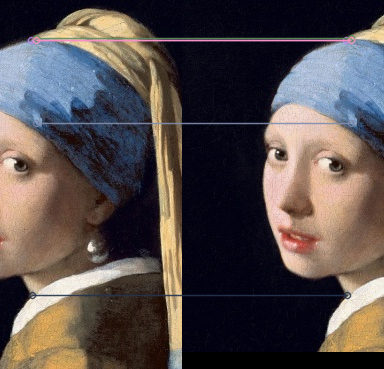

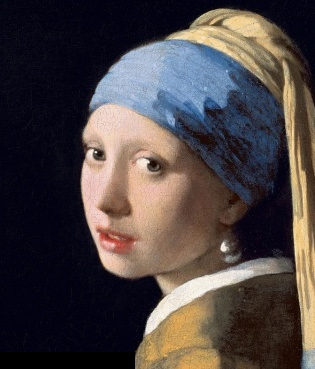

8 Matches were Found


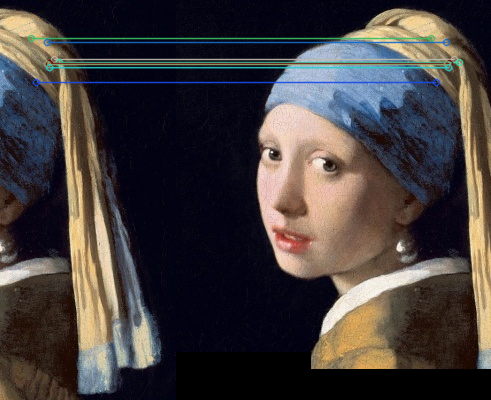

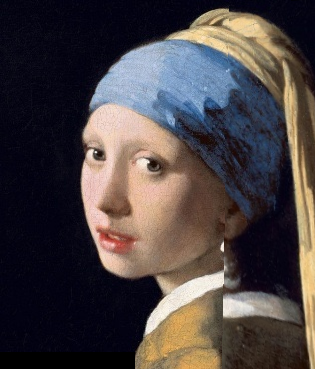

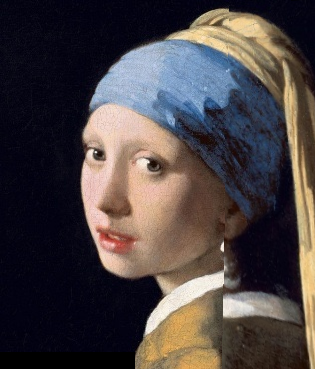

In [43]:
warped = warpPano(img1, img2)
warped = warpPano(warped, img3)

cv2_imshow(warped)